# Region detection with Tensorflow

In this notebook we will explore and end-to-end data generation and machine learning project.

That said, you will learn both programming and applied deep learning concepts.

The project is based on deep learning framework [Tensorflow](https://www.tensorflow.org/) and some add-ons.

We start by importing all required tools at once, letting the discussion of their use for later.

In [1]:
from majordome.ml.tf_common import plot_history
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow_addons.losses import GIoULoss
from tensorflow_addons.losses import giou_loss
import json
import numpy as np
import tensorflow as tf

%matplotlib inline

Since data will be generated withing this notebook and to enforce repeatable training, it is important to seed RNG utilities.

Keras API of Tensorflow provides [this](https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed) utility function to encapsulate all seeding process.

In [2]:
tf.keras.utils.set_random_seed(seed=42)

Since we will be working with deep convolutional neural networks (CNN) we can take profit from GPU acceleration.

This project was designed to be able to run on CPU"s as well but keep in mind that any serious CNN application will require (multi-)GPU.

The following line checks the available physical devices.

In [3]:
tf.config.list_physical_devices("GPU")

[]

## Creating the dataset

The goal of the project is to detect a bounding box around a rectangle present in an image.

To train the model we need first to generate the data for training and testing.

We will deal with two levels of difficulty of detection during this tutorial:
- In the first level we will simply look for an homogeneous square over an homogeneous background.
- Next we extend our study to noisy images, what could make CNN learning more difficult.

Using [NumPy](https://numpy.org/) we can easily allocate a matrix for representing an image.

Next cell provides and test a function for creating the *noisy* images because *simple* images are a special case.

To do so we make use of random number generators (RNG) for background/foreground creation.

We have also added optional parameters for setting foreground and background intensity levels.

You might wish to try later playing (and overlapping) these ranges to see impact on model.

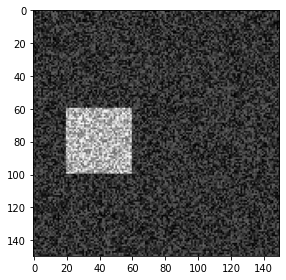

In [4]:
def gen_noisy_image(img_size, x, y, h, w, brng=(0, 100), frng=(100, 255)):
    """ Create a noisy background with a noisy lighter square.
    
    Parameters
    ----------
    img_size: int
        Full square image side length.
    x: int
        Horizontal coordinate of top-left corner of square.
    y: int
        Vertical coordinate of top-left corner of square.
    h: int
        Height of square over background.
    w: int
        Width of square over background.
    brng: tuple[int, int]
        Intensity range for background pixels.
    frng: tuple[int, int]
        Intensity range for foreground pixels.
        
    Returns
    -------
    np.ndarray[float]
        Array with 2D image data.
    """
    img = np.random.randint(*brng, size=(img_size, img_size))
    img[y:y + h, x:x + w] = np.random.randint(*frng, size=(h, w))
    return img


plt.imshow(gen_noisy_image(img_size=150, x=20, y=60, h=40, w=40), cmap="gray")
plt.tight_layout()

Basic *black and white* images are a special case of the noisy with restricted ranges on RNG.

We don"t actually need a function for this, but a special call to `gen_noisy_image`.

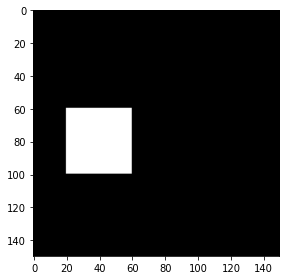

In [5]:
plt.imshow(gen_noisy_image(img_size=150, x=20, y=60, h=40, w=40, 
                           brng=(0, 1), frng=(254, 255)), cmap="gray")
plt.tight_layout()

To programmatically generate the dataset we need to manage the image and bounding box generation.

The *generalized intersection over union* metric provided by `tensorflow_addons` requires a specific format of data specification.

Function `gen_rect` wraps the call to the previous `gen_noisy_image` and returns the image with compatible labels.

A padding parameter is added so that we give a certain tolerance to the learning algorithm, otherwise failure is certain.

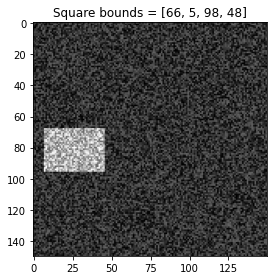

In [6]:
def gen_rect(img_size, rec_size, pad, noisy=((0, 100), (100, 255))):
    """ Create a dummy rectangle image over a background.
    
    Parameters
    ----------
    img_size: int
        Full square image side length.
    rec_size: int
        Maximum rectangle size over image, minimum value is half of this.
    pad: int
        Padding to be added to the bounding box as a tolerance.
    noisy: tuple[tuple[int, int], tuple[int, int]] = ((0, 100), (100, 255))
        Tuple of limits to noisy image intensity scales. The first tuple in
        the pair is for low intensity backgrounds and second one for clear
        foreground rectangle of random size based on `rec_size`.
        
    Returns
    -------
    tuple[np.ndarray[float], list[int]
        Generated image and bounding box of foreground region.
    """
    # Generate a point in the upper left region.
    x, y = np.random.randint(0, img_size // 2, 2)

    # Generate a random width and height.
    w, h = np.random.randint(rec_size // 2, rec_size , 2)

    # Apply bound to height and width.
    h = img_size - y - 1 if y + h > img_size else h
    w = img_size - x - 1 if x + w > img_size else w

    # Select method of image generation.
    brng, frng = ((0, 1), (254, 255)) if noisy is None else noisy

    # Create image with computed parameters.
    img = gen_noisy_image(img_size, x, y, h, w, brng=brng, frng=frng)

    # Notice the *pad* for allowing a broader bounding box.
    # For GIoULoss: [y_min, x_min, y_max, x_max]
    bbox = [
        max(y - pad, 0),
        max(x - pad, 0), 
        y + h + pad,
        x + w + pad
        ]
    return img, bbox


img, bbox = gen_rect(img_size=150, rec_size=40, pad=2)
plt.title(f"Square bounds = {bbox}")
plt.imshow(img, cmap="gray")
plt.tight_layout()

With these tools creating the dataset becomes simple.

We allocate empty arrays for storing lables and images and generate as many images as required.

Because the aim is to parametrize learning, actual use is left for later, just an example is made here.

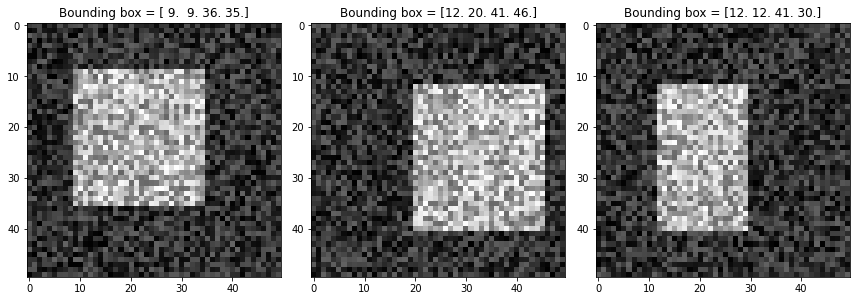

In [7]:
def create_data(num_imgs, img_size, pad=0, rec_size=None):
    """ Create database of images and bounding box labels.
    
    Parameters
    ----------
    num_imgs: int
        Number of images to create in dataset.
    img_size: int
        Full square image side length.
    pad: int = 0
        Padding to be added to the bounding box as a tolerance.
    rec_size: int = None
        Maximum rectangle size over image, minimum value is half of this.
        If not provided, rectangle will be at most 2/3 of total image size.
        
    Returns
    -------
    np.ndarray[float], np.ndarray[float]
        Arrays with images and respective bounding boxes.
    """
    bbox = np.empty((num_imgs, 4), dtype=float)
    imgs = np.empty((num_imgs, img_size, img_size), dtype=float)

    if rec_size is None:
        # Use 2/3 of width by default.
        rec_size =  2 * img_size // 3

    for i_img in range(num_imgs):
        img, xywh = gen_rect(img_size, rec_size, pad)
        imgs[i_img, :] = img
        bbox[i_img, :] = xywh

    return imgs, bbox


X_dummy, y_dummy = create_data(num_imgs=3, img_size=50)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title(f"Bounding box = {y_dummy[0]}")
ax[1].set_title(f"Bounding box = {y_dummy[1]}")
ax[2].set_title(f"Bounding box = {y_dummy[2]}")
ax[0].imshow(X_dummy[0], cmap="gray")
ax[1].imshow(X_dummy[1], cmap="gray")
ax[2].imshow(X_dummy[2], cmap="gray")
fig.tight_layout()

## Creating the model

In [26]:
def get_model(imp_shape):
    """ Generate model for single channel input. """
    opts = dict(strides=(1, 1), padding="same", activation="relu")
        
    layers = [
        # (1) convolution layer.
        Conv2D(4, 3, input_shape=imp_shape),
        MaxPooling2D(pool_size=(2, 2), padding="same"),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(8, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(16, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(32, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(64, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),
    
        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(128, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),
    
        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(256, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),
        
        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(512, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding="same"),
        
        # (3) flattening.
        Flatten(),
        BatchNormalization(axis=-1),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(8, activation="relu"),
        Dense(4)
    ]
    return Sequential(layers)

## Training the model

In [27]:
def get_model_and_data(num_imgs, img_size, pad, phi, rnd):
    """ Generate and preprocess model data. """
    # Create random data.
    X, y = create_data(num_imgs, img_size, pad=pad)
    X = X.reshape((-1, img_size, img_size, 1))

    # Perform global train test split.
    split = train_test_split(X, y, train_size=phi, random_state=rnd)
    train_X, tests_X, train_y, tests_y = split

    # Compute mean of *train* alone.
    mu = train_X.mean()
    std = train_X.std()

    # Transform input datasets.
    train_X = (train_X - mu) / std
    tests_X = (tests_X - mu) / std

    # Keep first image from training.
    # view_image(train_X[0], train_y[0], saveas="plot_sample.png")

    # Create model with proper dimensions.
    model = get_model((*train_X[0].shape,))

    return model, (train_X, tests_X, train_y, tests_y)

In [28]:
rnd = 42
phi = 0.8
vld = 0.2
pad = 1
num_imgs = 50_000
img_size = 64 * 1

In [29]:
rets = get_model_and_data(num_imgs, img_size, pad, phi, rnd)
model, (train_X, tests_X, train_y, tests_y) = rets

losses = [GIoULoss(mode="iou"), "mse"]
weights = [1, 1]
metric = "mae"
optim = "SGD"
optim = "adam"

# Compile model with loss and optimizer.
model.compile(optimizer=optim, 
              loss=losses, 
              loss_weights=weights,
              metrics=[metric])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 62, 62, 4)         40        
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 4)        0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 31, 31, 4)        16        
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 31, 31, 8)         296       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                      

In [30]:
# Create a callback for early training end.
early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)

# Train model with a validation set.
history = model.fit(train_X, train_y, epochs=100, batch_size=32,
                    validation_split=0.1, callbacks=[early])

Epoch 1/100
225/225 [==============================] - 17s 70ms/step - loss: 0.6902 - mae: 17.3494 - val_loss: 0.7562 - val_mae: 16.0930
Epoch 2/100
225/225 [==============================] - 15s 68ms/step - loss: 0.3871 - mae: 5.2588 - val_loss: 0.3242 - val_mae: 3.9476
Epoch 3/100
225/225 [==============================] - 15s 68ms/step - loss: 0.2665 - mae: 2.6926 - val_loss: 0.2245 - val_mae: 2.3660
Epoch 4/100
225/225 [==============================] - 16s 71ms/step - loss: 0.2478 - mae: 2.4719 - val_loss: 0.2192 - val_mae: 2.2454
Epoch 5/100
225/225 [==============================] - 15s 69ms/step - loss: 0.2200 - mae: 2.1216 - val_loss: 0.1764 - val_mae: 1.6526
Epoch 6/100
225/225 [==============================] - 15s 69ms/step - loss: 0.2064 - mae: 1.9535 - val_loss: 0.1767 - val_mae: 1.6933
Epoch 7/100
225/225 [==============================] - 15s 68ms/step - loss: 0.1972 - mae: 1.8658 - val_loss: 0.1654 - val_mae: 1.5242
Epoch 8/100
225/225 [==============================] 

## Evaluating the model

63/63 [==============================] - 1s 11ms/step - loss: 0.0710 - mae: 0.5982


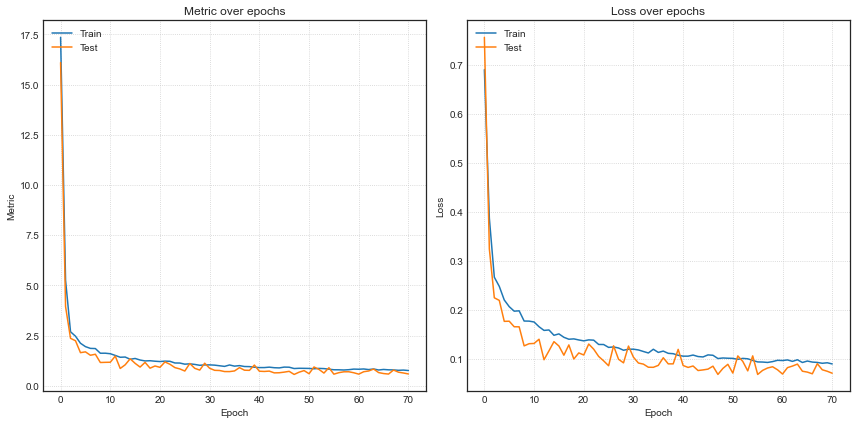

In [31]:
# Evaluate over test set.
results = model.evaluate(tests_X, tests_y, verbose=1)

# View training history.
fig = plot_history(history.history, metric)

In [17]:
results

[1.0, 30.99919891357422]

## Making predictions

In [35]:
def view_image(img, preds, actual=None, saveas=None):
    """ Display the image of a rectangle and bounding box. """
    y, x, y_m, x_m = preds
    w = x_m - x
    h = y_m - y

    plt.close("all")
    rect = Rectangle((x, y), w, h, ec="r", fc="none")
    plt.imshow(img, cmap="Greys", interpolation="none", 
               origin="lower", extent=[0, img.shape[0], 0, img.shape[1]])
    plt.gca().add_patch(rect)

    if actual is not None:
        # Calculate negative overlap between two bounding boxes.
        iou = 1 - giou_loss(preds, actual, mode="iou")
        plt.title(F"IOU: {iou:.2f}", color="r")

    if saveas is None:
        saveas = "plot_prediction.png"

    plt.savefig(saveas, dpi=200)

63/63 [==============================] - 1s 10ms/step


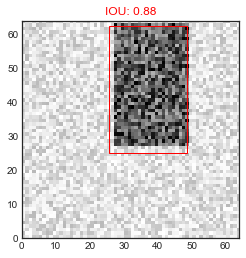

In [41]:
# Make predictions for visualization.
preds = model.predict(tests_X)

no_choices = 10
for k in np.random.choice(range(len(tests_X)), no_choices):
    saveas = F"plot_prediction_{k:04}.png"
    view_image(tests_X[k], preds[k], tests_y[k], saveas=saveas)

## Going to production

In [34]:
# Save model for re-use.
# model.save("model.h5")

# with open("metrics.json", "w") as fp:
#     json.dump({"loss": results}, fp)